In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd
import sklearn as sk
import joblib
import random
import gc
import matplotlib.pyplot as plt

2025-07-07 15:39:20.999975: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE3 SSE4.1 SSE4.2 AVX AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

In [2]:
print("Num GPUs Available:", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available: 0


In [3]:
df = pd.read_hdf("./dataset.h5", key="df")
df

,Cens_C,Cens_Db,Cens_D,Cens_Eb,Cens_E,Cens_F,Cens_Gb,Cens_G,Cens_Ab,Cens_A,Cens_Bb,Cens_B,chord
0,0.458163,0.228498,0.335618,0.385245,0.280831,0.562060,0.101404,0.142517,0.211683,0.000000,0.081103,0.007991,FMin7
1,0.456882,0.228481,0.329903,0.386718,0.270461,0.563033,0.104248,0.142325,0.223759,0.000000,0.096144,0.008832,FMin7
2,0.454308,0.229081,0.324611,0.388377,0.260669,0.563478,0.107217,0.142526,0.235052,0.000000,0.110957,0.009594,FMin7
3,0.450574,0.230340,0.319815,0.390179,0.251621,0.563336,0.110333,0.143008,0.245606,0.000000,0.125269,0.010269,FMin7
4,0.445894,0.232287,0.315578,0.392097,0.243367,0.562581,0.113524,0.143594,0.255459,0.000000,0.138864,0.010856,FMin7
...,...,...,...,...,...,...,...,...,...,...,...,...,...
108,0.207725,0.076254,0.397630,0.012440,0.081124,0.025550,0.113143,0.602074,0.253705,0.415162,0.012520,0.416366,AMin7
109,0.200846,0.072857,0.392787,0.013882,0.080756,0.028333,0.115661,0.609691,0.257939,0.416193,0.013882,0.409283,AMin7
110,0.194574,0.068975,0.387773,0.015407,0.080133,0.031256,0.117944,0.616832,0.261322,0.417602,0.015407,0.402578,AMin7
111,0.188929,0.064633,0.382609,0.017022,0.079286,0.034334,0.119918,0.623479,0.263771,0.419261,0.017022,0.396526,AMin7


In [4]:
print("Chords")
print(df["chord"].value_counts())

Chords
chord
CMin7     15869
AbMin7    15750
EMin7     15703
FMin7     15598
GbMin7    15512
DMaj7     15464
DbMin7    15426
GMaj7     15304
AMaj7     15211
AMin7     15030
BMin7     14976
BbMin7    14954
DMin7     14951
EMaj7     14919
GMin7     14885
AbMaj7    14869
BbMaj7    14862
EbMin7    14796
EbMaj7    14787
GbMaj7    14659
CMaj7     14659
BMaj7     14654
DbMaj7    14468
FMaj7     14444
G7         3414
C7         3321
Bb7        3311
B7         3258
Db7        3150
Ab7        3148
D7         3121
Eb7        3111
A7         3106
Gb7        3081
E7         3067
F7         3062
Name: count, dtype: int64


In [5]:
y = df["chord"]
X = df.drop(columns="chord")
encoder = sk.preprocessing.LabelEncoder()
y_encoded = encoder.fit_transform(y)

joblib.dump(encoder, "./encoder.xz")

['./encoder.xz']

In [6]:
del df
gc.collect()

20

# LSTM

In [7]:
SEQUENCE_LEN = 20 # 0.1 * 20.0 = 2 sec of sequence data

X_seq, y_encoded_seq = None, None
X_seq_list = []
y_encoded_seq_list = []
for i in range(len(X) - SEQUENCE_LEN + 1):
    X_seq_list.append(X.values[i : i + SEQUENCE_LEN, :])
    y_encoded_seq_list.append(y_encoded[i + SEQUENCE_LEN - 1])

X_seq, y_encoded_seq = np.array(X_seq_list), np.array(y_encoded_seq_list)

print("X sequence shape: ", X_seq.shape)
print("y sequence shape: ", y_encoded_seq.shape)

del X_seq_list
del y_encoded_seq_list
gc.collect()

X sequence shape:  (399881, 20, 12)
y sequence shape:  (399881,)


0

In [8]:
X_seq_flat = X_seq.reshape(X_seq.shape[0], -1)
_, unique_idx = np.unique(X_seq_flat, axis=0, return_index=True)
unique_idx = np.sort(unique_idx)

X_seq = X_seq[unique_idx]
y_encoded_seq = y_encoded_seq[unique_idx]

print("X deduplicate shape: ", X_seq.shape)
print("y deuplicate shape:  ", y_encoded_seq.shape)

del X_seq_flat
gc.collect()

X deduplicate shape:  (399881, 20, 12)
y deuplicate shape:   (399881,)


0

In [9]:
X_seq_train, X_seq_test, y_seq_train, y_seq_test = sk.model_selection.train_test_split(
    X_seq,
    y_encoded_seq,
    test_size=0.2,
    random_state=42,
    stratify=y_encoded_seq,
)

print(f"X_train: {len(X_seq_train)}")
print(f"y_train: {len(y_seq_train)}")
print(f"X_test:  {len(X_seq_test)}")
print(f"y_test:  {len(y_seq_test)}")

del X_seq
del y_encoded_seq
gc.collect()

X_train: 319904
y_train: 319904
X_test:  79977
y_test:  79977


0

In [10]:
print("Total feature: ", X_seq_train.shape[2])
print("Total class:   ", len(encoder.classes_))

Total feature:  12
Total class:    36


In [11]:
class_weights = sk.utils.class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_seq_train),
    y=y_seq_train,
)
class_weight_dict = dict(enumerate(class_weights))

In [12]:
model_lstm = tf.keras.Sequential([
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, return_sequences=True, input_shape=(SEQUENCE_LEN, X_seq_train.shape[2]))),
    tf.keras.layers.Dropout(0.25),
        
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, return_sequences=False)),
    tf.keras.layers.Dropout(0.25),

    tf.keras.layers.Dense(len(encoder.classes_), activation='softmax'),
])

model_lstm.compile(
    optimizer="adam",
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"],
)

model_lstm.summary()

/usr/lib/python3.13/site-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ bidirectional (Bidirectional)   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_1 (Bidirectional) │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [13]:
early_stopping = tf.keras.callbacks.EarlyStopping(
    patience=10,
    restore_best_weights=True,
)

history = model_lstm.fit(
    X_seq_train,
    y_seq_train,
    epochs=500,
    batch_size=32,
    validation_split=0.2,
    verbose=1,
    callbacks=[early_stopping],
    class_weight=class_weight_dict,
)

Epoch 1/500
7998/7998 ━━━━━━━━━━━━━━━━━━━━ 101s 12ms/step - accuracy: 0.5272 - loss: 1.6923 - val_accuracy: 0.6858 - val_loss: 1.0771
Epoch 2/500
7998/7998 ━━━━━━━━━━━━━━━━━━━━ 111s 14ms/step - accuracy: 0.6791 - loss: 1.0219 - val_accuracy: 0.7374 - val_loss: 0.8811
Epoch 3/500
7998/7998 ━━━━━━━━━━━━━━━━━━━━ 111s 14ms/step - accuracy: 0.7235 - loss: 0.8374 - val_accuracy: 0.7677 - val_loss: 0.7670
Epoch 4/500
7998/7998 ━━━━━━━━━━━━━━━━━━━━ 113s 14ms/step - accuracy: 0.7526 - loss: 0.7173 - val_accuracy: 0.7875 - val_loss: 0.6897
Epoch 5/500
7998/7998 ━━━━━━━━━━━━━━━━━━━━ 119s 15ms/step - accuracy: 0.7779 - loss: 0.6245 - val_accuracy: 0.8140 - val_loss: 0.6010
Epoch 6/500
7998/7998 ━━━━━━━━━━━━━━━━━━━━ 116s 15ms/step - accuracy: 0.7948 - loss: 0.5657 - val_accuracy: 0.8315 - val_loss: 0.5415
Epoch 7/500
7998/7998 ━━━━━━━━━━━━━━━━━━━━ 108s 14ms/step - accuracy: 0.8128 - loss: 0.5106 - val_accuracy: 0.8356 - val_loss: 0.5216
Epoch 8/500
7998/7998 ━━━━━━━━━━━━━━━━━━━━ 109s 14ms/step - ac

In [14]:
model_lstm.evaluate(X_seq_test, y_seq_test)
y_pred = np.argmax(model_lstm.predict(X_seq_test), axis=1)
print(
  sk.metrics.classification_report(y_seq_test, y_pred, target_names=encoder.classes_)
)

2500/2500 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - accuracy: 0.9490 - loss: 0.1748
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step
              precision    recall  f1-score   support

          A7       0.88      0.98      0.93       621
       AMaj7       0.95      0.96      0.95      3042
       AMin7       0.95      0.95      0.95      3006
         Ab7       0.88      0.98      0.93       630
      AbMaj7       0.95      0.95      0.95      2974
      AbMin7       0.96      0.94      0.95      3150
          B7       0.92      0.96      0.94       652
       BMaj7       0.96      0.94      0.95      2931
       BMin7       0.96      0.93      0.95      2995
         Bb7       0.87      0.98      0.92       662
      BbMaj7       0.96      0.95      0.96      2972
      BbMin7       0.96      0.93      0.95      2991
          C7       0.85      0.98      0.91       664
       CMaj7       0.96      0.95      0.95      2932
       CMin7       0.96      0.94      0.95      3174
          D7 

<Figure size 1600x1600 with 0 Axes>

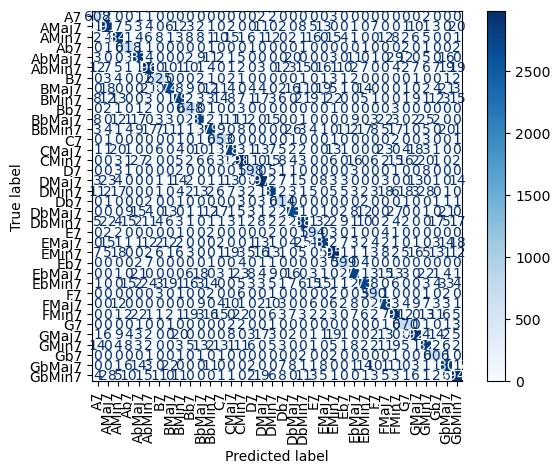

In [15]:
cm = sk.metrics.confusion_matrix(y_seq_test, y_pred)
disp = sk.metrics.ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=encoder.classes_)
plt.figure(figsize=(16, 16))
disp.plot(cmap="Blues", xticks_rotation=90)
plt.show()

In [16]:
model_lstm.save("model_lstm_cens_64_64.keras")
pd.DataFrame(history.history).to_csv("model_lstm_cens_64_64_history.csv", index=False)